In [53]:
import torch
from pathlib import Path


import matplotlib.pyplot as plt

In [2]:
import celeste.datasets.simulated_datasets as simulated_datasets
from celeste.datasets.simulated_datasets import get_fitted_powerlaw_psf
from celeste.datasets.galaxy_datasets import DecoderSamples

from celeste import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cpu
False


In [3]:
# create training dataset
n_bands = 1
max_stars = 20
mean_stars = 15
min_stars = 5
f_min = 1e4
slen = 50

simulator_kwargs = dict(
        slen=slen,
        n_bands=n_bands,
        max_sources=max_stars,
        mean_sources=mean_stars,
        min_sources=min_stars,
        f_min=f_min,
        prob_galaxy=0.5,  
    )

In [4]:
# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[0] = 686.0

In [5]:
# galaxy parameters
galaxy_decoder_file = data_path.joinpath("decoder_params_100_single_band_i.dat")
galaxy_slen = 51

# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")

n_images = 10
simulator_args = (
    DecoderSamples(galaxy_slen, galaxy_decoder_file, n_bands=n_bands),
    get_fitted_powerlaw_psf(psf_file)[0:n_bands],
    background,
)

In [6]:
dataset = simulated_datasets.SourceDataset(
        n_images, simulator_args, simulator_kwargs
    )

In [45]:
batchsize = 10
batch_params = dataset.get_batch(batchsize)

# Some checks

In [47]:
assert torch.all(batch_params['n_sources'] == (batch_params['n_stars'] + batch_params['n_galaxies']))

In [48]:
is_on_array = \
    simulated_datasets.get_is_on_from_n_sources(batch_params['n_sources'], dataset.simulator.max_sources)

In [49]:
# check correct pattern in locs
assert torch.all((batch_params['locs'] * is_on_array.unsqueeze(-1)) == batch_params['locs'])
assert torch.all((batch_params['locs'] * (1 - is_on_array).unsqueeze(-1)) == 0.0)

In [50]:
# check patterns in galaxy params and fluxes
assert torch.all(batch_params['galaxy_params'] * batch_params['galaxy_bool'].unsqueeze(-1) == \
                 batch_params['galaxy_params'])
assert torch.all(batch_params['galaxy_params'] * (1 - batch_params['galaxy_bool'].unsqueeze(-1)) == 0)

assert torch.all(batch_params['log_fluxes'] * (1 - batch_params['galaxy_bool'].unsqueeze(-1)) == \
                 batch_params['log_fluxes'])
assert torch.all(batch_params['log_fluxes'] * batch_params['galaxy_bool'].unsqueeze(-1) == 0)

# Plot images

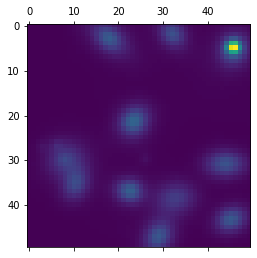

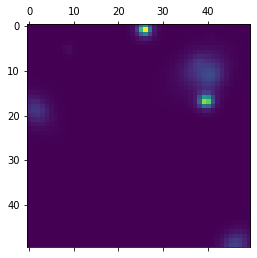

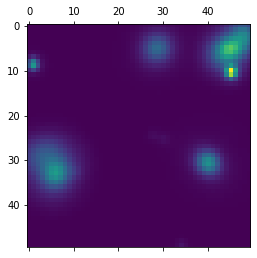

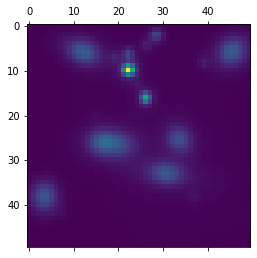

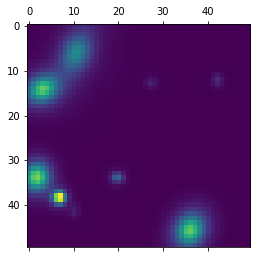

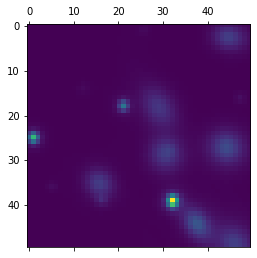

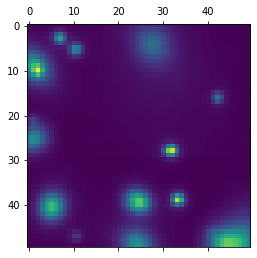

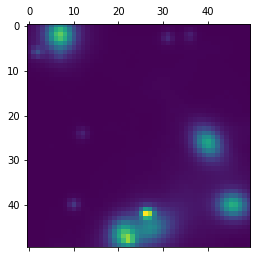

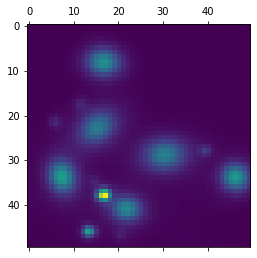

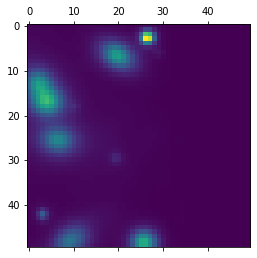

In [56]:
for i in range(batchsize): 
    plt.matshow(batch_params['images'][i, 0])